Homework set 3

In [2]:
#importing libraries
import numpy as np
from scipy.interpolate import CubicSpline
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt

## Problem 9.3


In [7]:
#parameters
gamma, beta, alpha_c, alpha_i, depreciation_rate = 0.5, 0.99, 0.5, 0.5, 0.075
lower_bound, upper_bound, convergence_threshold, iterations, grid_size = 5.0, 100.0, 1e-6, 2000, 100
verbose = True

capital_grid = np.linspace(lower_bound, upper_bound, grid_size+1)
consumption_grid = capital_grid - (depreciation_rate*capital_grid)**(1/alpha_i)

In [3]:
def compute_next_k(consumption_capital, total_capital):
    return (1-depreciation_rate)*total_capital + (total_capital-consumption_capital)**alpha_i

def compute_next_consumption_capital (next_k,spline):
    next_consumption_capital = spline(next_k)
    return np.clip(next_consumption_capital, convergence_threshold, next_k-convergence_threshold)

def inspect_foc(consumption_guess, total_capital, spline):
    consumption_capital = np.clip(consumption_guess, convergence_threshold, total_capital-convergence_threshold)
    next_k = compute_next_k(consumption_capital, total_capital)
    next_consumption_capital = compute_next_consumption_capital(next_k, spline)

    first_term = beta*(1-depreciation_rate+alpha_i*(next_k-next_consumption_capital)**(alpha_i-1))
    second_term = np.maximum((consumption_capital - next_consumption_capital),convergence_threshold)**(1-alpha_c)
    third_term = ((next_k-next_consumption_capital)/(total_capital-consumption_capital))**(1-alpha_i)

    return consumption_capital - (first_term*second_term*third_term)**(-depreciation_rate/alpha_c)

def policy_function(consumption_grid):
    new_consumption_capital = np.zeros_like(consumption_grid)
    for iteration in range(iterations):
        spline = CubicSpline(capital_grid, consumption_grid, bc_type="natural", extrapolate=True)

        for i, total_capital in enumerate(capital_grid):
            solution = root_scalar(inspect_foc, args=(total_capital, spline), bracket=[convergence_threshold, total_capital-convergence_threshold], xtol=convergence_threshold)
            new_consumption_capital[i] = solution.root if solution.converged else capital_grid[i]

        convergence = np.max(np.abs(new_consumption_capital - consumption_grid) / np.maximum(np.abs(consumption_grid), convergence_threshold))

        if verbose:
            print(f"Iteration {iteration+1}: Convergence = {convergence}")

        if convergence < convergence_threshold:
            print(f"Converged in {iteration+1} iterations")
            return new_consumption_capital
        consumption_grid = new_consumption_capital

    print("Did not converge.")
    return new_consumption_capital





In [4]:

solved_consumption = policy_function(consumption_grid)
print(solved_consumption)

Iteration 1: Convergence = 0.9335863136473894
Iteration 2: Convergence = 0.0
Converged in 2 iterations
[2.68488177 2.70410782 2.71772849 2.72809965 2.73638401 2.74322318
 2.74900953 2.7539978  2.75836283 2.7622292  2.76568862 2.76881037
 2.77164799 2.77424364 2.77663103 2.77883757 2.78088574 2.78279426
 2.78457881 2.7862527  2.78782727 2.78931226 2.79071612 2.79204621
 2.79330895 2.79451    2.79565438 2.79674653 2.79779042 2.79878965
 2.79974737 2.80066644 2.80154945 2.80239826 2.80321601 2.80400417
 2.80476453 2.80549872 2.80620824 2.80689448 2.80755871 2.80820212
 2.80882579 2.80943075 2.81001792 2.81058818 2.81114234 2.81168117
 2.81220538 2.81271563 2.81321253 2.81369669 2.81416863 2.81462888
 2.81507793 2.81551622 2.81594419 2.81636225 2.81677079 2.81717015
 2.8175607  2.81794275 2.81831661 2.81868259 2.81904095 2.81939197
 2.81973588 2.82007295 2.82040339 2.82072742 2.82104525 2.82135708
 2.82166309 2.82196348 2.82225841 2.82254805 2.82283256 2.82311209
 2.82338679 2.82365679 2.8

## Problem 9.9

We consider Hansen (1985) stochastic growth model with indivisible labour.  
A fraction $\kappa$ of households works full time $h_0 < 1$, while the rest enjoys leisure.  
Aggregate labour supply in the economy: $\alpha h_0$.

The utility function:

$u(c,\kappa) = \log c + A \kappa \log (1 - h_0).$


Bellman equation:
$
V(\hat{k}_v,\hat{\eta}_g) = \max_{c,\kappa} \left\{
\log c + A \kappa \log (1 - h_0) + \beta \sum_{g^+=1}^m \pi_{gg^+} V(k^+,\hat{\eta}_{g^+})
\right\}
$

subject to:
$
(1-\delta) \hat{k}_v + \exp(\hat{\eta}_g) \hat{k}_v^\alpha (\kappa h_0)^{1-\alpha} = c + k^+.
$


Define the Lagrangian:
$
\mathcal{L} = \log c + A \kappa \log (1 - h_0) + \beta \sum_{g^+=1}^m \pi_{gg^+} V(k^+,\hat{\eta}_{g^+}) + \lambda \left[
(1-\delta) \hat{k}_v + \exp(\hat{\eta}_g) \hat{k}_v^\alpha (\kappa h_0)^{1-\alpha} - c - k^+
\right].
$

### Optimality conditions

$\frac{\partial{\mathcal{L}}}{\partial{c}}$:
$
\frac{1}{c} - \lambda = 0 \implies \lambda = \frac{1}{c}.
$

$\frac{\partial{\mathcal{L}}}{\partial{\kappa}}$:
$
A \log(1 - h_0) + \lambda \exp(\hat{\eta}_g) \hat{k}_v^\alpha (1-\alpha) (\kappa h_0)^{-\alpha} h_0 = 0.
$

$\frac{\partial{\mathcal{L}}}{\partial{k^+}}$:
$
\beta \sum_{g^+=1}^m \pi_{gg^+} V_{k}(k^+,\hat{\eta}_{g^+}) - \lambda = 0.
$

### Envelope theorem yields
$
V_{k}(\hat{k}_v,\hat{\eta}_g)
= \lambda \left[
(1-\delta) + \exp(\hat{\eta}_g) \alpha \hat{k}_v^{\alpha-1} (\kappa h_0)^{1-\alpha}
\right].
$

### Euler equation
$
\frac{1}{c} = \beta \sum_{g^+=1}^m \pi_{gg^+} V_{k}(k^+,\hat{\eta}_{g^+}).
$

Final kappa policy shape: (100, 21)
Final consumption policy shape: (100, 21)


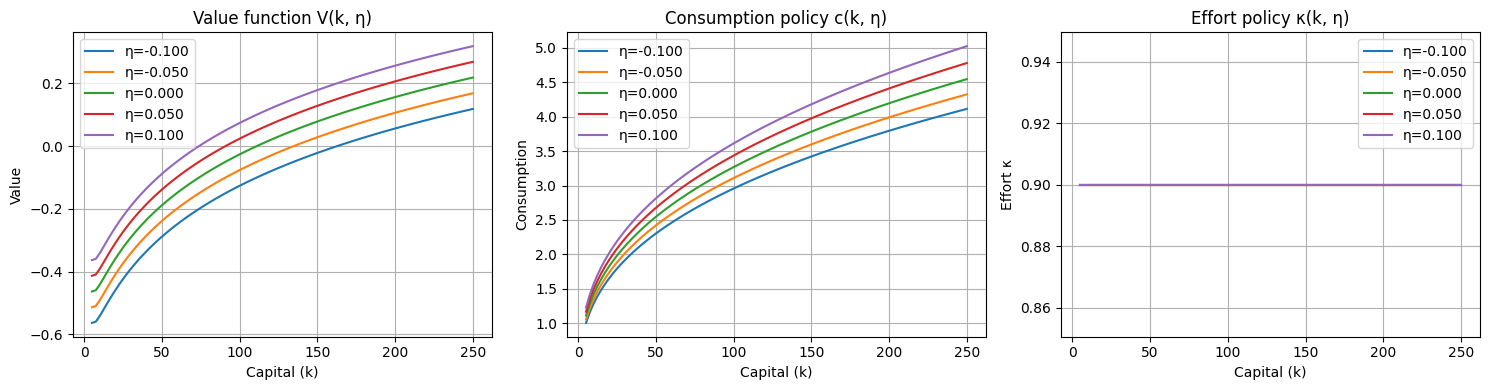

C:\Users\oluri\AppData\Local\Temp\ipykernel_25020\3133136763.py:249: RuntimeWarning: invalid value encountered in scalar power
  y_t[t] = np.exp(eta_t[t]) * k_t[t]**self.alpha * (kappa_t[t]*self.h0)**(1 - self.alpha)


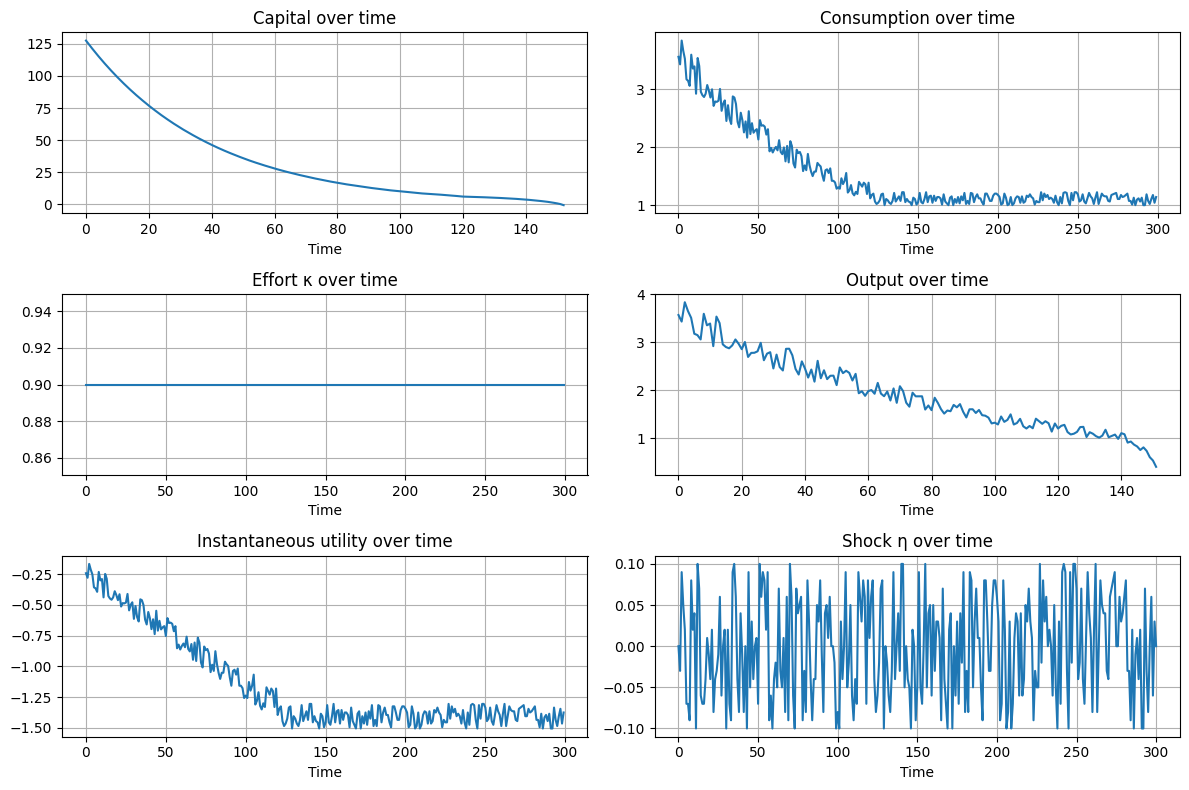

: 

In [ ]:
class HansenModel:

    def __init__(self):
        # Model parameters
        self.A = 2.0
        self.h0 = 0.53
        self.beta = 0.99
        self.alpha = 0.36
        self.delta = 0.025
        self.rho = 0.95
        self.sigma_eps = (0.712e-2)**2

        # bounds
        self.k_lower_bound = 5.0
        self.k_upper_bound = 250.0
        self.convergence_threshold = 1e-6
        self.max_iterations = 2000


        # Shock process
        self.number_of_shock_states = 21  # number of shock states
        self.number_of_capital_grid_points = 100  # number of capital grid points
        self.eta = np.zeros(self.number_of_shock_states)
        self.pi = np.zeros((self.number_of_shock_states, self.number_of_shock_states))

        # Grids and policy functions
        self.k = np.linspace(self.k_lower_bound, self.k_upper_bound, self.number_of_capital_grid_points)
        self.kappa = np.zeros((self.number_of_capital_grid_points, self.number_of_shock_states))
        self.c = np.zeros((self.number_of_capital_grid_points, self.number_of_shock_states))
        self.c_new = np.zeros((self.number_of_capital_grid_points, self.number_of_shock_states))
        self.RHS = np.zeros((self.number_of_capital_grid_points, self.number_of_shock_states))

        # Placeholder for spline coefficients (not needed if using CubicSpline directly)
        self.splines = [None] * self.number_of_shock_states  # list of CubicSpline objects, one per shock

    def discretize_ar(self):
        """
        Dummy AR(1) discretization; replace with Tauchen or Rouwenhorst.
        """
        self.eta = np.linspace(-0.1, 0.1, self.number_of_shock_states)
        self.pi[:, :] = 1 / self.number_of_shock_states

    def initialize_policy(self):
        """
        Initialize kappa and consumption policies.
        """
        for i in range(self.number_of_shock_states):
            self.kappa[:, i] = 0.9
            self.c[:, i] = np.exp(self.eta[i]) * self.k**self.alpha * (self.kappa[:, i] * self.h0)**(1 - self.alpha)
            self.c_new[:, i] = self.c[:, i]

    def interpolate(self):
        """
        Calculate RHS and fit splines for each shock state.
        """
        for i in range(self.number_of_shock_states):
            rhs_values = np.zeros(self.number_of_capital_grid_points)
            for j in range(self.number_of_capital_grid_points):
                acc = 0.0
                for k in range(self.number_of_shock_states):
                    term = 1 + self.alpha * np.exp(self.eta[k]) * \
                        (self.k[j] / (self.kappa[j, k] * self.h0))**(self.alpha - 1) - self.delta
                    acc += self.pi[i, k] * term / self.c_new[j, k]
                rhs_values[j] = self.beta * acc
            self.RHS[:, i] = rhs_values
            self.splines[i] = CubicSpline(self.k, rhs_values, extrapolate=False)

    def foc(self, kappa_guess, current_capital, shock_state_id):
        """
        First-order condition residual.
        """
        kappa_act = np.clip(kappa_guess, 1e-10, 1 - 1e-10)

        c_act = -(1 - self.alpha) * np.exp(self.eta[shock_state_id]) * \
                (current_capital / (kappa_act * self.h0))**self.alpha * self.h0 / (self.A * np.log(1 - self.h0))

        kplus = (1 - self.delta) * current_capital + np.exp(self.eta[shock_state_id]) * current_capital**self.alpha * (kappa_act * self.h0)**(1 - self.alpha) - c_act

        if kplus <= self.k_upper_bound:
            rhs_val = self.splines[shock_state_id](kplus)
        else:
            # Linear extrapolation if kplus > k_upper_bound
            slope = (self.RHS[-1, shock_state_id] - self.RHS[-2, shock_state_id]) / (self.k[-1] - self.k[-2])
            rhs_val = slope * (kplus - self.k_upper_bound) + self.RHS[-1, shock_state_id]

        return 1.0 / c_act - rhs_val

    def solve(self, verbose=False):
        """
        Iterate until policy convergence.
        """
        self.discretize_ar()
        self.initialize_policy()

        damping = 0.9  # weight on previous c (for smoothing)
        
        for iter in range(1, self.max_iterations + 1):
            # Step 1: update interpolants
            self.interpolate()

            for j in range(self.number_of_capital_grid_points):
                current_k = self.k[j]
                
                for s in range(self.number_of_shock_states):
                    x0 = self.kappa[j, s]
                    
                    # Step 2: check sign change in bracket
                    f_lower = self.foc(1e-8, current_k, s)
                    f_upper = self.foc(1.0, current_k, s)
                    
                    if np.isnan(f_lower) or np.isnan(f_upper):
                        if verbose:
                            print(f"[Warning] NaN in FOC at iter={iter}, k_idx={j}, shock_idx={s}")
                        continue

                    if f_lower * f_upper > 0:
                        if verbose:
                            print(f"[Info] No sign change in FOC at iter={iter}, k_idx={j}, shock_idx={s}. "
                                f"f(0)={f_lower:.4e}, f(1)={f_upper:.4e}")
                        # fallback: keep last κ
                        continue
                    for κ in [0.1, 0.5, 0.9, 0.99]:
                        val = self.foc(κ, current_k, s)
                        print(f"FOC at κ={κ:.2f}: {val:.4e}")
                    # Step 3: solve for optimal κ
                    try:
                        sol = root_scalar(
                            self.foc, args=(current_k, s),
                            method='bisect', bracket=[1e-8, 1.0], x0=x0
                        )
                        if sol.converged:
                            self.kappa[j, s] = sol.root
                        else:
                            if verbose:
                                print(f"[Warning] Root finding did not converge at iter={iter}, k_idx={j}, shock_idx={s}")
                            # fallback: keep last κ
                    except Exception as e:
                        if verbose:
                            print(f"[Error] Exception in root finding at iter={iter}, k_idx={j}, shock_idx={s}: {e}")
                        # fallback: keep last κ

                    # Step 4: update consumption policy based on new κ
                    try:
                        self.c_new[j, s] = -(1 - self.alpha) * np.exp(self.eta[s]) * \
                            (current_k / (self.kappa[j, s] * self.h0))**self.alpha * self.h0 / \
                            (self.A * np.log(1 - self.h0))
                    except Exception as e:
                        if verbose:
                            print(f"[Error] Failed to compute c_new at iter={iter}, k_idx={j}, shock_idx={s}: {e}")
                        self.c_new[j, s] = 1e-8  # fallback small positive

            # Step 5: check convergence
            con_lev = np.max(np.abs(self.c_new - self.c) / np.maximum(np.abs(self.c), 1e-10))
            if verbose:
                print(f"Iter {iter:4d} | Convergence level: {con_lev:.7e}")

            if con_lev < self.convergence_threshold:
                if verbose:
                    print("Converged!")
                return

            # Step 6: damping update
            self.c = damping * self.c + (1 - damping) * self.c_new

        print("[Warning] Maximum iterations reached without convergence.")
    
    
    
    def report(self, shock_indices=None):
        """
        Print or plot results (placeholder).
        """
        print("Final kappa policy shape:", self.kappa.shape)
        print("Final consumption policy shape:", self.c.shape)
        if shock_indices is None:
        # Pick 5 evenly spaced indices
            shock_indices = np.linspace(0, self.number_of_shock_states - 1, 5, dtype=int)

        const_term = self.A * np.log(1 - self.h0)

        #plot
        plt.figure(figsize=(15, 4))

        # value function
        plt.subplot(1, 3, 1)
        for i in shock_indices:
            utility = np.log(self.c[:, i]) + const_term
            continuation = self.RHS[:, i]  # already β × E[…]
            V = utility + continuation
            plt.plot(self.k, V, label=f"η={self.eta[i]:.3f}")
        plt.title("Value function V(k, η)")
        plt.xlabel("Capital (k)")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(True)

        # consumption policy
        plt.subplot(1, 3, 2)
        for i in shock_indices:
            plt.plot(self.k, self.c[:, i], label=f"η={self.eta[i]:.3f}")
        plt.title("Consumption policy c(k, η)")
        plt.xlabel("Capital (k)")
        plt.ylabel("Consumption")
        plt.legend()
        plt.grid(True)

        # kappa policy
        plt.subplot(1, 3, 3)
        for i in shock_indices:
            plt.plot(self.k, self.kappa[:, i], label=f"η={self.eta[i]:.3f}")
        plt.title("Effort policy κ(k, η)")
        plt.xlabel("Capital (k)")
        plt.ylabel("Effort κ")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def simulate_and_plot_time_series(self, T=300, seed=42):
        np.random.seed(seed)

        # Start from steady state or mid-point
        k_t = np.zeros(T+1)
        c_t = np.zeros(T)
        kappa_t = np.zeros(T)
        y_t = np.zeros(T)
        utility_t = np.zeros(T)
        shock_idx_t = np.zeros(T+1, dtype=int)
        eta_t = np.zeros(T+1)

        k_t[0] = np.mean(self.k)  # start at mean capital

        # Initial shock state: middle index
        shock_idx_t[0] = self.number_of_shock_states // 2
        eta_t[0] = self.eta[shock_idx_t[0]]

        for t in range(T):
            # Get policy at current k and shock:
            # Find nearest k grid point
            ik = np.argmin(np.abs(self.k - k_t[t]))
            is_ = shock_idx_t[t]

            c_t[t] = self.c[ik, is_]
            kappa_t[t] = self.kappa[ik, is_]
            eta_t[t] = self.eta[is_]

            # Compute output
            y_t[t] = np.exp(eta_t[t]) * k_t[t]**self.alpha * (kappa_t[t]*self.h0)**(1 - self.alpha)

            # Instantaneous utility
            utility_t[t] = np.log(c_t[t]) + self.A * np.log(1 - self.h0)

            # Next capital
            k_t[t+1] = (1 - self.delta)*k_t[t] + y_t[t] - c_t[t]

            # Draw next shock index
            shock_idx_t[t+1] = np.random.choice(
                self.number_of_shock_states, p=self.pi[is_]
            )

        # Plot
        fig, axs = plt.subplots(3, 2, figsize=(12, 8))

        axs[0,0].plot(k_t[:-1])
        axs[0,0].set_title("Capital over time")
        axs[0,0].set_xlabel("Time")
        axs[0,0].grid(True)

        axs[0,1].plot(c_t)
        axs[0,1].set_title("Consumption over time")
        axs[0,1].set_xlabel("Time")
        axs[0,1].grid(True)

        axs[1,0].plot(kappa_t)
        axs[1,0].set_title("Effort κ over time")
        axs[1,0].set_xlabel("Time")
        axs[1,0].grid(True)

        axs[1,1].plot(y_t)
        axs[1,1].set_title("Output over time")
        axs[1,1].set_xlabel("Time")
        axs[1,1].grid(True)

        axs[2,0].plot(utility_t)
        axs[2,0].set_title("Instantaneous utility over time")
        axs[2,0].set_xlabel("Time")
        axs[2,0].grid(True)

        axs[2,1].plot(eta_t)
        axs[2,1].set_title("Shock η over time")
        axs[2,1].set_xlabel("Time")
        axs[2,1].grid(True)

        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    model = HansenModel()
    model.solve()
    model.report()
    model.simulate_and_plot_time_series()


## 9.11

Consider the following tax scheme:
$
g_t = \tau^w_t w_t l_t.
$

Lump sum taxation is excluded

## Household utility

Households maximize expected lifetime utility:
$
\max_{\{c_t, l_t, k_{t+1}\}} E_0 \sum_{t=0}^\infty \beta^t u(c_t, l_t)
$

subject to:
$
c_t + k_{t+1} = (1-\delta) k_t + (1-\tau^w_t) w_t l_t + r_t k_t.
$


## Lagrangian and optimality conditions

$
\mathcal{L} = E_0 \sum_{t=0}^\infty \beta^t \big[
u(c_t, l_t) + \lambda_t \big((1-\delta) k_t + (1-\tau^w_t) w_t l_t + r_t k_t - c_t - k_{t+1}\big)
\big].
$




### $\frac{\partial{\mathcal{L}}}{{\partial{(c_t)}}}$:
$
u_c(c_t, l_t) - \lambda_t = 0 
\quad \Rightarrow \quad \lambda_t = u_c(c_t, l_t).
$


### $\frac{\partial{\mathcal{L}}}{\partial{(l_t)}}$:
$
u_l(c_t, l_t) + \lambda_t (1-\tau^w_t) w_t = 0
$
$
\Rightarrow u_l(c_t, l_t) = - u_c(c_t, l_t) (1-\tau^w_t) w_t.
$


### $\frac{\partial{\mathcal{L}}}{\partial{(k_{t+1})}}$:
$
-\lambda_t + \beta E_t[\lambda_{t+1} (r_{t+1} + 1 - \delta)] = 0
$
$
\Rightarrow 1 = \beta E_t \left[\frac{u_c(c_{t+1}, l_{t+1})}{u_c(c_t, l_t)} (r_{t+1} + 1 - \delta) \right].
$


## Euler equation:
$
1 = \beta E_t \left[\frac{u_c(c_{t+1}, l_{t+1})}{u_c(c_t, l_t)} (r_{t+1} + 1 - \delta) \right].
$

## Intratemporal (labour supply) condition:
$
u_l(c_t, l_t) = - u_c(c_t, l_t) (1-\tau^w_t) w_t.
$

## B Implementation

* Modification of household budget constraint:
$
c_t + k_{t+1} = (1-\delta) k_t + (1-\tau^w_t) w_t l_t + r_t k_t.
$

* Government tax revenue:
$
g_t = \tau^w_t w_t l_t.
$

---

### Computational steps:
- Discretize productivity shocks 
- Use a capital grid and shock grid to iterate and state \((k_t, \eta_t)\):
- Compute \( w_t, r_t \) from the production function.
- Compute the tax rate:
$
\tau^w_t = \frac{g_t}{w_t l_t}.
$
- Update the function with $((1-\tau^w_t)w_tl_t)$ instead of $(w_t l_t)$.

---

## C Policy comparison
Compare 
1. Constant government spending: $(g_t = \bar{g})$
2. Procyclical government consumption: $(g_t)$ increasing function in $(\eta_t)$


### Effect on endogenous \tau:
- constant spending:  
  When $(w_t l_t)$ rises $(\tau^w_t = g_t / (w_t l_t))$ falls, leading to a countercyclical tax rate.

- **Procyclical $(g_t)$**:  
  $(g_t)$ rises with $(w_t l_t)$, keeping $(\tau^w_t)$ stable or increasing.

---

### Comparison to lump-sum:
- With lump-sum taxes, optimality condiotions become:
$
u_l(c_t, l_t) = - u_c(c_t, l_t) w_t.
$
This does not affect labor incentives, only income.


$
u_l(c_t, l_t) / u_c(c_t, l_t) = - (1-\tau^w_t) w_t.
$
Affects labour incentives and welfare.

---

## Welfare cost
- Simulate the model for both cases
- Plot:
    * $(\tau^w_t)$ in $t$
    * Labour supply $(l_t)$
    * Output $(y_t)$, consumption $(c_t)$
- Expected welfare:
$
E_0 \sum_{t=0}^\infty \beta^t u(c_t, l_t).
$
- Compare policies.

---

## summery:
* Distortionary taxes endogenises variation in tax rates.
* Procyclical government spending keeps $\tau$ stable, but increase volatility.
* Constant government spending implies countercyclical $\tau$. This has a consumption smoothing effect, but crowds out labor during recession.


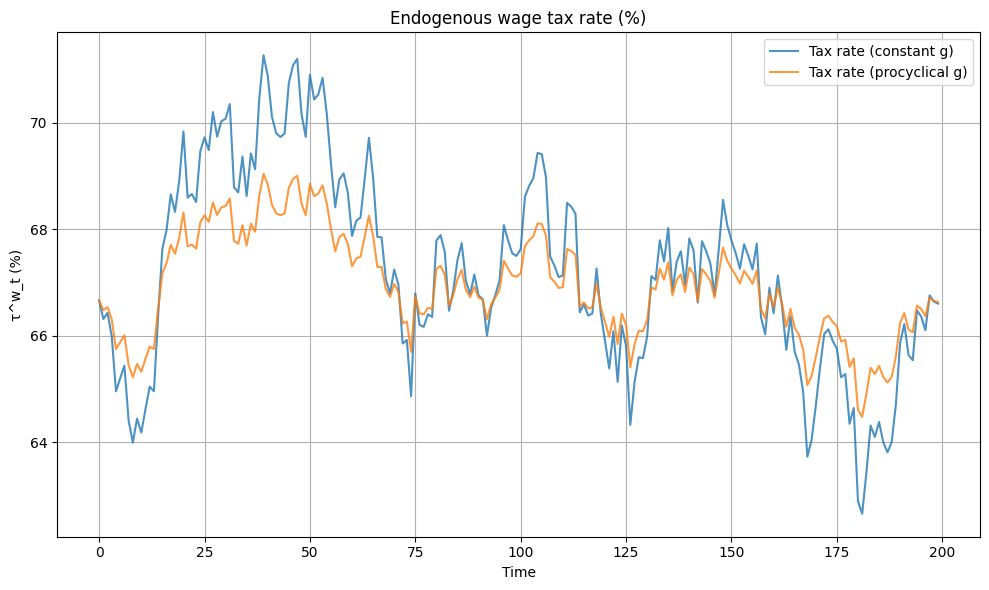

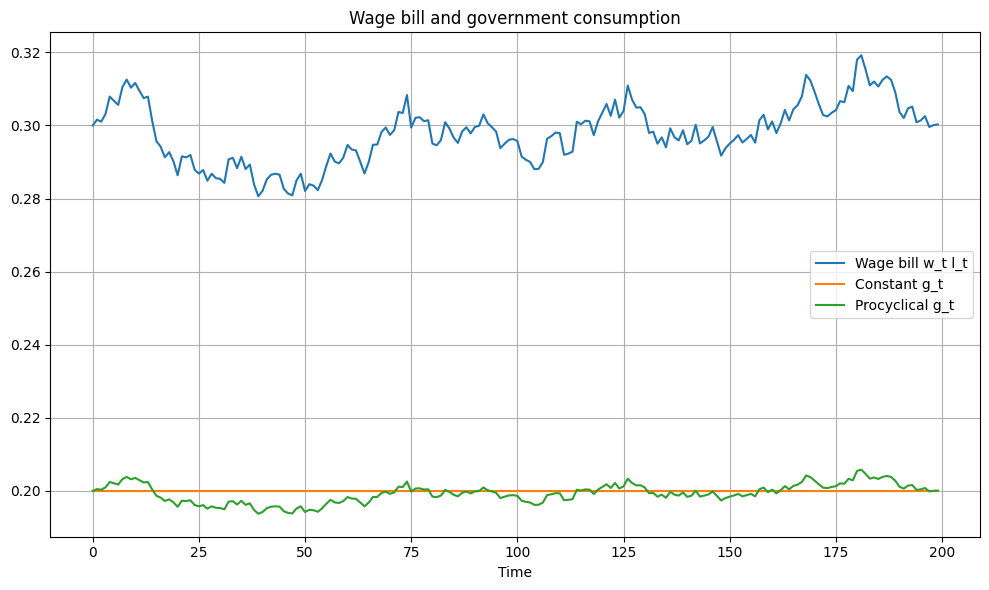

In [5]:

np.random.seed(42)

periods = 200  # periods
persistence = 0.95
shock_std = 0.01

#Simulate productivity shocks
eta = np.zeros(periods)
for t in range(1, periods):
    eta[t] = persistence * eta[t-1] + shock_std * np.random.randn()

# Assume baseline wage and labour supply (simplified)
w_base = np.exp(eta)  # wage as a simple function in eta (productivity)
l_base = 0.3 + 0.02 * eta  # Productivity as a simple function in eta (increasing)

# Scenario 1: constant spend
g_const = np.full(periods, 0.2)  # some constant level
tau_const = g_const / (w_base * l_base)

# Scenario 2: procyclical spend
g_procyclical = 0.2 * (1 + 0.5 * eta)  # spend increases in booms
tau_procyclical = g_procyclical / (w_base * l_base)

# Plot
plt.figure(figsize=(10,6))
plt.plot(tau_const * 100, label="Tax rate (constant)", alpha=0.8)
plt.plot(tau_procyclical * 100, label="Tax rate (procyclical)", alpha=0.8)
plt.title("Endogenous wage tax rate (%)")
plt.xlabel("Time")
plt.ylabel("τ^w_t (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: plot consumption or labour supply variations
plt.figure(figsize=(10,6))
plt.plot(w_base * l_base, label="Wage bill w_t l_t")
plt.plot(g_const, label="Constant g_t")
plt.plot(g_procyclical, label="Procyclical g_t")
plt.title("Wage bill and government consumption")
plt.xlabel("Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
